In [ ]:
import cv2
import os

# Directory containing the images
image_dir_part1 = "HAM1000"

# Function to read and preprocess images
def preprocess_images_inplace(image_dir):
    for filename in os.listdir(image_dir):
        image_path = os.path.join(image_dir, filename)
        img = cv2.imread(image_path)
        if img is not None:
            # Resize image to the specified width and height
            width = 512
            height = 512
            img = cv2.resize(img, (width, height))
            
            # Convert RGB image to grayscale
            gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            
            # Apply Morphological Black-Hat transformation
            kernel_size = 15  # Adjust kernel size as needed
            kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
            blackhat_image = cv2.morphologyEx(gray_image, cv2.MORPH_BLACKHAT, kernel)
            
            # Create a mask for inpainting task
            _, mask = cv2.threshold(blackhat_image, 10, 255, cv2.THRESH_BINARY)
            mask = cv2.resize(mask, (img.shape[1], img.shape[0]))
            
            # Apply inpainting algorithm on the original image using the mask
            img = cv2.inpaint(img, mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)

            # Save the modified image, overwriting the original file
            cv2.imwrite(image_path, img)
            
        else:
            print("Error reading image:", image_path)

# Process images in both parts
preprocess_images_inplace(image_dir_part1)

print("Images processed successfully.")


In [ ]:

import matplotlib.pyplot as plt

# Directory containing the images
image_dir = "HAM1000"

# Function to display the first 10 images using pyplot
def display_first_10_images(image_dir):
    count = 0
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    for filename in os.listdir(image_dir):
        if count >= 10:
            break
        image_path = os.path.join(image_dir, filename)
        image = cv2.imread(image_path)
        axes[count // 5, count % 5].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        axes[count // 5, count % 5].set_title(f"Image {count+1}")
        axes[count // 5, count % 5].axis("off")
        count += 1
    plt.show()

# Display the first 10 images
display_first_10_images(image_dir)


In [ ]:
import numpy as np


# Function to perform GrabCut segmentation on an image
def perform_grabcut(image_path):
    try:
        # Read the input image
        image = cv2.imread(image_path)

        # Check if the image is valid
        if image is not None and image.size > 0:
            # Create a mask initialized with zeros
            mask = np.zeros(image.shape[:2], dtype=np.uint8)

            # Initialize the rectangle for GrabCut
            rect = (50, 50, image.shape[1]-50, image.shape[0]-50)
            

            # Initialize the foreground and background models
            bgdModel = np.zeros((1, 65), np.float64)
            fgdModel = np.zeros((1, 65), np.float64)

            # Apply GrabCut segmentation
            cv2.grabCut(image, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)

            # Modify the mask to make all non-zero pixels (sure foreground and likely foreground) to be 1
            mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')

            # Apply the modified mask to the input image
            segmented_image = image * mask2[:, :, np.newaxis]

            # Save the segmented image back to its original location
            cv2.imwrite(image_path, segmented_image)
        else:
            print(f"Error: Invalid image or size for {image_path}")
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")


# Perform GrabCut segmentation on images in the first directory
for filename in os.listdir(image_dir_part1):
    image_path = os.path.join(image_dir_part1, filename)
    perform_grabcut(image_path)

print("Segmentation complete for all images.")


In [4]:
import cv2
print(cv2.__version__)

4.9.0


In [5]:
import cv2
import numpy as np
import os
import pandas as pd
from skimage.feature import greycomatrix, greycoprops

# Function to compute GLCM features
def calculate_glcm_features(image):
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Compute the GLCM
    glcm = greycomatrix(gray_image, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    
    # Calculate GLCM properties
    contrast = greycoprops(glcm, 'contrast')[0, 0]
    energy = greycoprops(glcm, 'energy')[0, 0]
    correlation = greycoprops(glcm, 'correlation')[0, 0]
    homogeneity = greycoprops(glcm, 'homogeneity')[0, 0]
    entropy = greycoprops(glcm, 'ASM')[0, 0]  # Using ASM as a proxy for entropy

    return contrast, energy, correlation, homogeneity, entropy

# Function to compute statistical features
def calculate_statistical_features(image):
    # Convert the image to RGB color space
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Calculate statistical features
    mean = np.mean(rgb_image, axis=(0, 1))
    variance = np.var(rgb_image, axis=(0, 1))
    std_deviation = np.std(rgb_image, axis=(0, 1))
    root_mean_square = np.sqrt(np.mean(rgb_image ** 2, axis=(0, 1)))

    return mean, variance, std_deviation, root_mean_square

# Function to extract features from an image
def extract_features(image):
    glcm_features = calculate_glcm_features(image)
    statistical_features = calculate_statistical_features(image)
    return glcm_features, statistical_features

# Function to perform feature extraction on an image
def perform_feature_extraction(image_path):
    try:
        # Read the input image
        image = cv2.imread(image_path)

        # Check if the image is valid
        if image is not None and image.size > 0:
            # Extract features
            glcm_features, statistical_features = extract_features(image)
            
            # Create a DataFrame to store the features
            data = {
                'GLCM_Contrast': glcm_features[0],
                'GLCM_Energy': glcm_features[1],
                'GLCM_Correlation': glcm_features[2],
                'GLCM_Homogeneity': glcm_features[3],
                'GLCM_Entropy': glcm_features[4],
                'Mean_R': statistical_features[0][0],
                'Mean_G': statistical_features[0][1],
                'Mean_B': statistical_features[0][2],
                'Variance_R': statistical_features[1][0],
                'Variance_G': statistical_features[1][1],
                'Variance_B': statistical_features[1][2],
                'Std_Deviation_R': statistical_features[2][0],
                'Std_Deviation_G': statistical_features[2][1],
                'Std_Deviation_B': statistical_features[2][2],
                'Root_Mean_Square_R': statistical_features[3][0],
                'Root_Mean_Square_G': statistical_features[3][1],
                'Root_Mean_Square_B': statistical_features[3][2]
            }

            df = pd.DataFrame(data, index=[0])

            return df
        else:
            print(f"Error: Invalid image or size for {image_path}")
            return None
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

# Directory containing the images
image_dir_part1 = "HAM1000"

# Create an empty DataFrame to store all features
all_features_df = pd.DataFrame()

# Perform feature extraction on images in the first directory
for filename in os.listdir(image_dir_part1):
    image_path = os.path.join(image_dir_part1, filename)
    df = perform_feature_extraction(image_path)
    if df is not None:
        all_features_df = all_features_df.append(df, ignore_index=True)

# Perform feature extraction on images in the second directory
for filename in os.listdir(image_dir_part2):
    image_path = os.path.join(image_dir_part2, filename)
    df = perform_feature_extraction(image_path)
    if df is not None:
        all_features_df = all_features_df.append(df, ignore_index=True)

# Save all features to a CSV file
csv_filename = "all_image_features.csv"
all_features_df.to_csv(csv_filename, index=False)

print(f"All features saved to {csv_filename}.")


All features saved to all_image_features.csv.


In [6]:
# Read the metadata CSV file
metadata_df = pd.read_csv("1000_metadata.csv")

# Read the existing features CSV file
all_features_df = pd.read_csv("all_image_features.csv")

# Merge the metadata with the existing features DataFrame
merged_df = pd.merge(all_features_df, metadata_df, left_index=True, right_index=True)

# Save the merged DataFrame to a new CSV file
merged_df.to_csv("merged_image_features.csv", index=False)

print("Merged data saved to merged_image_features.csv.")


Merged data saved to merged_image_features.csv.


<Figure size 864x576 with 0 Axes>

<Figure size 720x432 with 0 Axes>

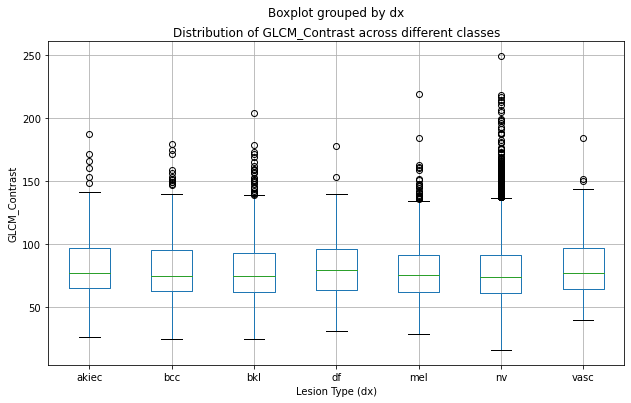

<Figure size 720x432 with 0 Axes>

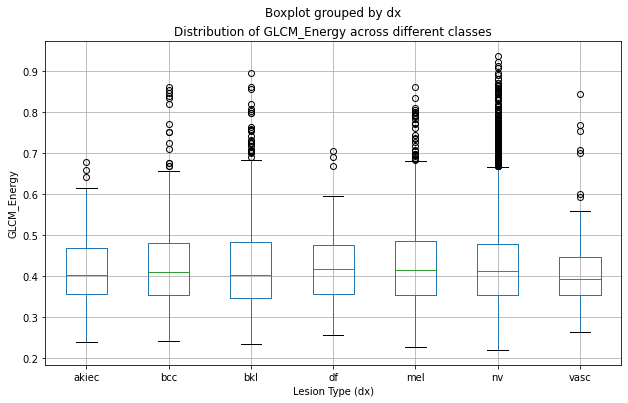

<Figure size 720x432 with 0 Axes>

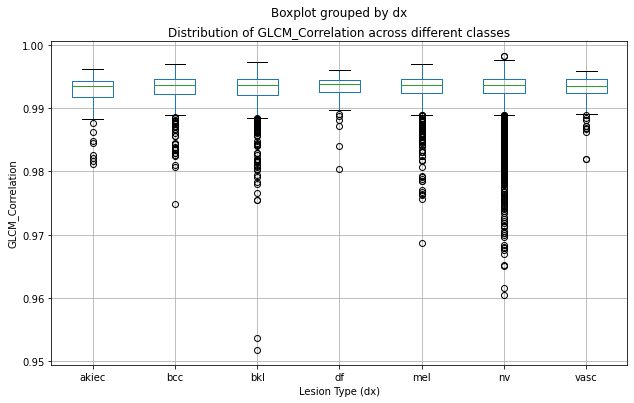

<Figure size 720x432 with 0 Axes>

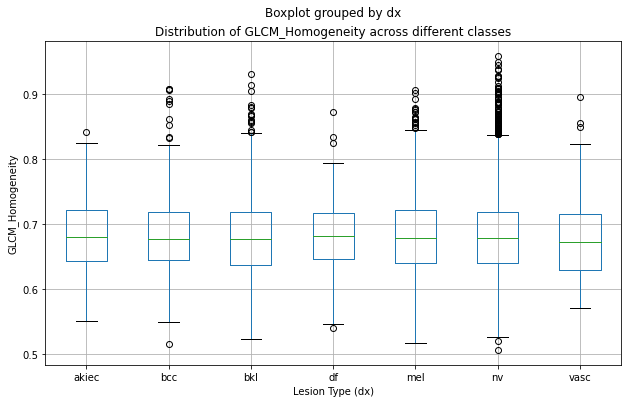

<Figure size 720x432 with 0 Axes>

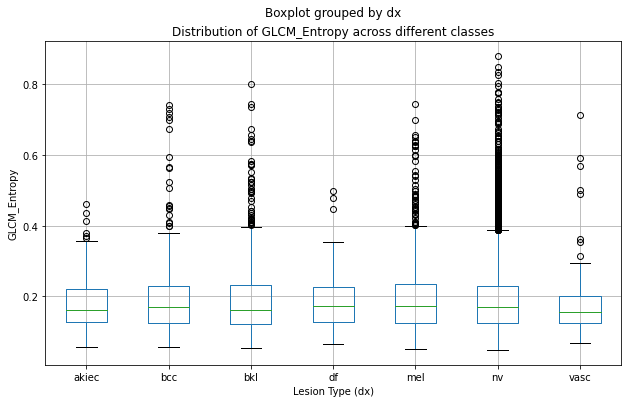

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the merged data
merged_df = pd.read_csv("merged_image_features.csv")

# Select features for visualization
features = ['GLCM_Contrast', 'GLCM_Energy', 'GLCM_Correlation', 'GLCM_Homogeneity', 'GLCM_Entropy']

# Plot the distribution of selected features across different classes (dx)
plt.figure(figsize=(12, 8))
for feature in features:
    plt.figure(figsize=(10,6))
    merged_df.boxplot(column=feature, by='dx', figsize=(10,6))
    plt.title(f'Distribution of {feature} across different classes')
    plt.xlabel('Lesion Type (dx)')
    plt.ylabel(feature)
    plt.show()


In [2]:
# Check for missing values
missing_values = merged_df.isnull().sum()

print(f"missing values{missing_values}")
# Impute missing values with mean for numerical columns
numeric_cols = merged_df.select_dtypes(include='number').columns
merged_df[numeric_cols] = merged_df[numeric_cols].fillna(merged_df[numeric_cols].mean())


missing valuesGLCM_Contrast          0
GLCM_Energy            0
GLCM_Correlation       0
GLCM_Homogeneity       0
GLCM_Entropy           0
Mean_R                 0
Mean_G                 0
Mean_B                 0
Variance_R             0
Variance_G             0
Variance_B             0
Std_Deviation_R        0
Std_Deviation_G        0
Std_Deviation_B        0
Root_Mean_Square_R     0
Root_Mean_Square_G     0
Root_Mean_Square_B     0
lesion_id              0
image_id               0
dx                     0
dx_type                0
age                   57
sex                    0
localization           0
dtype: int64


In [3]:
missing_values

GLCM_Contrast          0
GLCM_Energy            0
GLCM_Correlation       0
GLCM_Homogeneity       0
GLCM_Entropy           0
Mean_R                 0
Mean_G                 0
Mean_B                 0
Variance_R             0
Variance_G             0
Variance_B             0
Std_Deviation_R        0
Std_Deviation_G        0
Std_Deviation_B        0
Root_Mean_Square_R     0
Root_Mean_Square_G     0
Root_Mean_Square_B     0
lesion_id              0
image_id               0
dx                     0
dx_type                0
age                   57
sex                    0
localization           0
dtype: int64

In [4]:
merged_df

,GLCM_Contrast,GLCM_Energy,GLCM_Correlation,GLCM_Homogeneity,GLCM_Entropy,Mean_R,Mean_G,Mean_B,Variance_R,Variance_G,...,Root_Mean_Square_R,Root_Mean_Square_G,Root_Mean_Square_B,lesion_id,image_id,dx,dx_type,age,sex,localization
0,60.074651,0.509274,0.993580,0.724240,0.259360,91.483959,45.927090,44.241020,10182.159693,3145.165052,...,7.293034,6.868372,6.477776,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,56.861703,0.370334,0.994912,0.657579,0.137147,130.453091,74.172558,76.329788,10946.023411,3891.459997,...,8.494314,7.693913,7.970897,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,80.321516,0.378341,0.992670,0.618005,0.143142,116.772434,63.022198,60.757988,10079.124388,4174.347678,...,8.305507,8.175120,8.273327,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,41.454776,0.498463,0.994777,0.737336,0.248466,85.729210,43.903893,49.297504,8390.832137,2612.547984,...,7.191811,6.585388,6.488883,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,83.777879,0.490491,0.993263,0.681485,0.240581,93.469872,61.749943,60.390190,10226.846848,4865.819403,...,7.455065,7.107217,7.172552,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10010,94.740773,0.399416,0.991085,0.640638,0.159533,93.482887,69.808167,77.039803,7104.626546,4596.226033,...,7.680319,7.923640,7.949233,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen
10011,89.878558,0.449173,0.995729,0.738250,0.201756,106.219807,96.937714,95.289131,11393.375044,10186.049114,...,7.910011,8.055999,8.088720,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen
10012,71.897960,0.415081,0.994026,0.677160,0.172292,92.640053,73.745941,82.630760,7103.219605,5530.873313,...,7.491047,8.102809,7.734807,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen
10013,54.542495,0.374984,0.993340,0.635429,0.140613,88.695717,67.547413,68.876057,5471.721575,3568.264468,...,8.038992,6.392170,7.063279,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face


In [12]:
from sklearn.preprocessing import LabelEncoder

# Initialize a LabelEncoder object
label_encoder = LabelEncoder()

# Encode the categorical variables "dx" and "dx_type" into numerical values
merged_df['dx_encoded'] = label_encoder.fit_transform(merged_df['dx'])
merged_df['dx_type_encoded'] = label_encoder.fit_transform(merged_df['dx_type'])
merged_df['sex_encoded'] = label_encoder.fit_transform(merged_df['sex'])
merged_df['localization_encoded'] = label_encoder.fit_transform(merged_df['localization'])

merged_df.to_csv("encoded_dataset.csv", index=False)


In [13]:

merged_df.to_csv("encoded_dataset.csv", index=False)

In [14]:
merged_df

,GLCM_Contrast,GLCM_Energy,GLCM_Correlation,GLCM_Homogeneity,GLCM_Entropy,Mean_R,Mean_G,Mean_B,Variance_R,Variance_G,...,Root_Mean_Square_B,dx,dx_type,age,sex,localization,dx_encoded,dx_type_encoded,sex_encoded,localization_encoded
0,60.074651,0.509274,0.993580,0.724240,0.259360,91.483959,45.927090,44.241020,10182.159693,3145.165052,...,6.477776,bkl,histo,80.0,male,scalp,2,3,1,11
1,56.861703,0.370334,0.994912,0.657579,0.137147,130.453091,74.172558,76.329788,10946.023411,3891.459997,...,7.970897,bkl,histo,80.0,male,scalp,2,3,1,11
2,80.321516,0.378341,0.992670,0.618005,0.143142,116.772434,63.022198,60.757988,10079.124388,4174.347678,...,8.273327,bkl,histo,80.0,male,scalp,2,3,1,11
3,41.454776,0.498463,0.994777,0.737336,0.248466,85.729210,43.903893,49.297504,8390.832137,2612.547984,...,6.488883,bkl,histo,80.0,male,scalp,2,3,1,11
4,83.777879,0.490491,0.993263,0.681485,0.240581,93.469872,61.749943,60.390190,10226.846848,4865.819403,...,7.172552,bkl,histo,75.0,male,ear,2,3,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10010,94.740773,0.399416,0.991085,0.640638,0.159533,93.482887,69.808167,77.039803,7104.626546,4596.226033,...,7.949233,akiec,histo,40.0,male,abdomen,0,3,1,0
10011,89.878558,0.449173,0.995729,0.738250,0.201756,106.219807,96.937714,95.289131,11393.375044,10186.049114,...,8.088720,akiec,histo,40.0,male,abdomen,0,3,1,0
10012,71.897960,0.415081,0.994026,0.677160,0.172292,92.640053,73.745941,82.630760,7103.219605,5530.873313,...,7.734807,akiec,histo,40.0,male,abdomen,0,3,1,0
10013,54.542495,0.374984,0.993340,0.635429,0.140613,88.695717,67.547413,68.876057,5471.721575,3568.264468,...,7.063279,akiec,histo,80.0,male,face,0,3,1,5


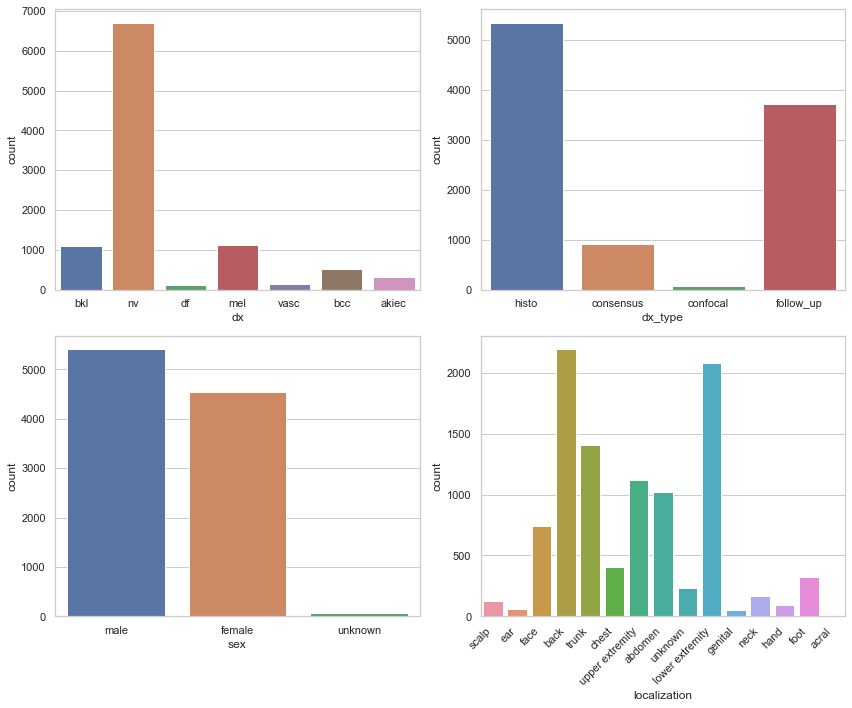

In [15]:
import seaborn as sns

sns.set(style="whitegrid")

# Plot count plots for each categorical feature
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
sns.countplot(x='dx', data=merged_df)

plt.subplot(2, 2, 2)
sns.countplot(x='dx_type', data=merged_df)

plt.subplot(2, 2, 3)
sns.countplot(x='sex', data=merged_df)

plt.subplot(2, 2, 4)
sns.countplot(x='localization', data=merged_df)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility

plt.tight_layout()
plt.show()

# Run From this side now

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Load the encoded dataset
merged_df = pd.read_csv("encoded_dataset.csv")

# merged_df = merged_df.drop(['lesion_id','image_id'], axis=1)

# Separate features and target variable
X = merged_df.drop(['dx_encoded', 'dx', 'sex', 'dx_type', 'localization'], axis=1)  # Features
y = merged_df['dx_encoded']  # Target variable

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 1. Correlation Analysis
correlation_matrix = X_train.corrwith(y_train)
selected_features_corr = correlation_matrix.abs().nlargest(6).index
print("Top features selected using correlation analysis:")
print(selected_features_corr)

# 2. Feature Importance
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
feature_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
selected_features_importance = feature_importances.nlargest(6).index
print("\nTop features selected using feature importance:")
print(selected_features_importance)


Top features selected using correlation analysis:
Index(['age', 'dx_type_encoded', 'sex_encoded', 'localization_encoded',
       'GLCM_Contrast', 'Variance_B'],
      dtype='object')

Top features selected using feature importance:
Index(['dx_type_encoded', 'age', 'localization_encoded', 'Variance_R',
       'Std_Deviation_R', 'GLCM_Homogeneity'],
      dtype='object')


In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

# Extract the selected features from your dataset
X_train_selected = X_train[selected_features_corr]
X_test_selected = X_test[selected_features_corr]

# Initialize the decision tree classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Train the classifier on the training data with selected features
dt_classifier.fit(X_train_selected, y_train)

# Predict on the test data with selected features
y_pred = dt_classifier.predict(X_test_selected)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Generate classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)


Accuracy: 0.6645032451323015
Classification Report:
               precision    recall  f1-score   support

           0       0.17      0.20      0.19        69
           1       0.20      0.27      0.23        93
           2       0.42      0.39      0.40       228
           3       0.33      0.21      0.26        28
           4       0.25      0.25      0.25       226
           5       0.86      0.85      0.86      1338
           6       0.14      0.14      0.14        21

    accuracy                           0.66      2003
   macro avg       0.34      0.33      0.33      2003
weighted avg       0.67      0.66      0.67      2003



In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

# Extract the selected features from your dataset
X_train_selected = X_train[selected_features_importance]
X_test_selected = X_test[selected_features_importance]

# Initialize the decision tree classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Train the classifier on the training data with selected features
dt_classifier.fit(X_train_selected, y_train)

# Predict on the test data with selected features
y_pred = dt_classifier.predict(X_test_selected)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Generate classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)


Accuracy: 0.6380429355966051
Classification Report:
               precision    recall  f1-score   support

           0       0.18      0.19      0.19        69
           1       0.13      0.15      0.14        93
           2       0.35      0.36      0.35       228
           3       0.24      0.21      0.23        28
           4       0.22      0.23      0.23       226
           5       0.86      0.83      0.84      1338
           6       0.08      0.10      0.09        21

    accuracy                           0.64      2003
   macro avg       0.29      0.30      0.29      2003
weighted avg       0.65      0.64      0.64      2003



# Random Forest on Unbalanced Data


In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Extract the selected features from your dataset
X_train_selected = X_train[selected_features_corr]
X_test_selected = X_test[selected_features_corr]

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier on the training data
rf_classifier.fit(X_train_selected, y_train)

# Predict the labels for the test data
y_pred = rf_classifier.predict(X_test_selected)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Generate classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)



Accuracy: 0.7134298552171743
Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.29      0.31        69
           1       0.29      0.19      0.23        93
           2       0.45      0.40      0.42       228
           3       0.62      0.18      0.28        28
           4       0.33      0.29      0.31       226
           5       0.84      0.92      0.88      1338
           6       0.00      0.00      0.00        21

    accuracy                           0.71      2003
   macro avg       0.41      0.32      0.35      2003
weighted avg       0.68      0.71      0.69      2003



In [29]:
from sklearn.svm import SVC

# Extract the selected features from your dataset
X_train_selected = X_train[selected_features_corr]
X_test_selected = X_test[selected_features_corr]

# Initialize the SVM classifier
svm_classifier = SVC(kernel='rbf', random_state=42)

# Train the classifier on the training data
svm_classifier.fit(X_train_selected, y_train)

# Predict the labels for the test data
y_pred_svm = svm_classifier.predict(X_test_selected)

# Calculate the accuracy of the model
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("SVM Accuracy:", accuracy_svm)

# Generate classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)


SVM Accuracy: 0.6679980029955067


# Now Over Sampling Done

In [5]:
from imblearn.over_sampling import RandomOverSampler

# Assuming your dataset is named df
# Select features and target variable
X = merged_df.drop(['dx_encoded', 'dx', 'sex', 'dx_type', 'localization'], axis=1)  # Features
y = merged_df['dx_encoded']  # Target variable

# Initialize RandomOverSampler
oversampler = RandomOverSampler(random_state=42)

# Resample the dataset
X_resampled, y_resampled = oversampler.fit_resample(X, y)

# Check the class distribution after oversampling
class_distribution = y_resampled.value_counts().to_dict()
print("Class distribution after oversampling:", class_distribution)


Class distribution after oversampling: {2: 6705, 5: 6705, 3: 6705, 4: 6705, 6: 6705, 1: 6705, 0: 6705}


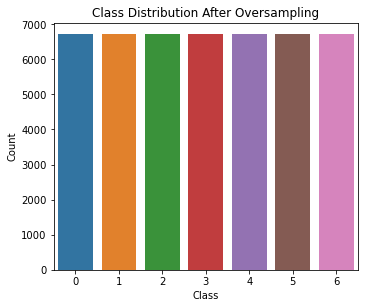

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
sns.countplot(x=y_resampled)
plt.title('Class Distribution After Oversampling')
plt.xlabel('Class')
plt.ylabel('Count')

plt.show()

In [7]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# 1. Correlation Analysis
correlation_matrix = X_train.corrwith(y_train)
selected_features_corr = correlation_matrix.abs().nlargest(6).index
print("Top features selected using correlation analysis:")
print(selected_features_corr)

# 2. Feature Importance
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
feature_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
selected_features_importance = feature_importances.nlargest(6).index
print("\nTop features selected using feature importance:")
print(selected_features_importance)

Top features selected using correlation analysis:
Index(['age', 'dx_type_encoded', 'Std_Deviation_R', 'Variance_R', 'Mean_R',
       'sex_encoded'],
      dtype='object')

Top features selected using feature importance:
Index(['dx_type_encoded', 'age', 'localization_encoded', 'Std_Deviation_R',
       'Variance_R', 'GLCM_Correlation'],
      dtype='object')


In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

# Extract the selected features from your dataset
X_train_selected = X_train[selected_features_corr]
X_test_selected = X_test[selected_features_corr]

# Initialize the decision tree classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Train the classifier on the training data with selected features
dt_classifier.fit(X_train_selected, y_train)

# Predict on the test data with selected features
y_pred = dt_classifier.predict(X_test_selected)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Generate classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)


Accuracy: 0.972728241184617
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1295
           1       0.97      1.00      0.98      1323
           2       0.95      0.99      0.97      1351
           3       0.99      1.00      1.00      1392
           4       0.94      1.00      0.97      1312
           5       0.99      0.82      0.90      1346
           6       0.99      1.00      1.00      1368

    accuracy                           0.97      9387
   macro avg       0.97      0.97      0.97      9387
weighted avg       0.97      0.97      0.97      9387



# **Random forest after Oversampling**

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Extract the selected features from your dataset
X_train_selected = X_train[selected_features_corr]
X_test_selected = X_test[selected_features_corr]

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier on the training data
rf_classifier.fit(X_train_selected, y_train)

# Predict the labels for the test data
y_pred = rf_classifier.predict(X_test_selected)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Generate classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

Accuracy: 0.9751784382656866
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1295
           1       0.98      1.00      0.99      1323
           2       0.95      0.99      0.97      1351
           3       1.00      1.00      1.00      1392
           4       0.94      1.00      0.97      1312
           5       1.00      0.84      0.91      1346
           6       1.00      1.00      1.00      1368

    accuracy                           0.98      9387
   macro avg       0.98      0.98      0.97      9387
weighted avg       0.98      0.98      0.97      9387



In [35]:
from sklearn.svm import SVC

# Extract the selected features from your dataset
X_train_selected = X_train[selected_features_corr]
X_test_selected = X_test[selected_features_corr]

# Initialize the SVM classifier
svm_classifier = SVC(kernel='rbf', random_state=42)

# Train the classifier on the training data
svm_classifier.fit(X_train_selected, y_train)

# Predict the labels for the test data
y_pred_svm = svm_classifier.predict(X_test_selected)

# Calculate the accuracy of the model
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("SVM Accuracy:", accuracy_svm)


SVM Accuracy: 0.22520507084265473


# Ensemble Learning

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC


# Extract the selected features from your dataset
X_train_selected = X_train[selected_features_corr]
X_test_selected = X_test[selected_features_corr]

# Initialize base classifiers
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
dt_classifier = DecisionTreeClassifier(random_state=42)
svm_classifier = SVC(kernel='linear', random_state=42)

# Initialize Voting Classifier with the base classifiers
voting_classifier = VotingClassifier(estimators=[
    ('rf', rf_classifier),
    ('dt', dt_classifier),
    ('svm', svm_classifier)
], voting='hard')  # 'hard' voting: majority rule voting

# Train the Voting Classifier on the training data
voting_classifier.fit(X_train_selected, y_train)

# Predict the labels for the test data
y_pred_voting = voting_classifier.predict(X_test_selected)

# Calculate the accuracy of the ensemble model
accuracy_voting = accuracy_score(y_test, y_pred_voting)
print("Voting Classifier Accuracy:", accuracy_voting)
